<a href="https://colab.research.google.com/github/sidvin101/interpretable-ml/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #03
### Interpretable ML
### Siddarth Vinnakota

## DO:
* Use markdown and comments effectively
* Pull out classes and functions into scripts
* Ensure cells are executed in order and avoid skipping cells to maintain reproducibility
* Choose the appropriate runtime (i.e. GPU) if needed
* If you are using a dataset that is too large to put in your GitHub repository, you must either pull it in via Hugging Face Datasets or put it in an S3 bucket and use boto3 to pull from there.
* Use versioning on all installs (ie pandas==1.3.0) to ensure consistency across versions
* Implement error handling where appropriate

## DON'T:
* Absolutely NO sending us Google Drive links or zip files with data (see above).
* Load packages throughout the notebook. Please load all packages in the first code cell in your notebook.
* Add API keys or tokens directly to your notebook!!!! EVER!!!
* Include cells that you used for testing or debugging. Delete these before submission
* Have errors rendered in your notebook. Fix errors prior to submission.

In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "interpretable-ml" # Change to your repo name
git_path = 'https://github.com/sidvin101/interpretable-ml' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
#notebook_dir = 'templates'
#path_to_notebook = os.path.join(repo_name,notebook_dir)
#%cd "{path_to_notebook}"
#%ls

rm: cannot remove './sample_data': No such file or directory
fatal: destination path 'interpretable-ml' already exists and is not an empty directory.


In [2]:
pip install pygam

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pygam import LinearGAM, GammaGAM, s
from scipy import stats
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Gamma
from statsmodels.genmod.families.links import Log
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools import add_constant

In [4]:
#importing the dataset
df = pd.read_csv('/content/interpretable-ml/customer_churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Exploratory Data Analysis

In [5]:
df.shape

(7043, 21)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [8]:
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'customerID': ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Unique values in column 'gender': ['Female' 'Male']
Unique values in column 'SeniorCitizen': [0 1]
Unique values in column 'Partner': ['Yes' 'No']
Unique values in column 'Dependents': ['No' 'Yes']
Unique values in column 'tenure': [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
Unique values in column 'PhoneService': ['No' 'Yes']
Unique values in column 'MultipleLines': ['No phone service' 'No' 'Yes']
Unique values in column 'InternetService': ['DSL' 'Fiber optic' 'No']
Unique values in column 'OnlineSecurity': ['No' 'Yes' 'No internet service']
Unique values in column 'OnlineBackup': ['Yes' 'No' 'No internet service']
Unique values in column 'DeviceProtection': ['No' 'Yes' 'No internet serv

In [9]:
#Drop unncessary columns (having a strange issue with TotalCharges, so I'm removing it too)
df = df.drop(columns=['customerID', 'TotalCharges'])
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,Yes


In [10]:
#Perform numerical encoding, either with label for binary values or onehot for nominal values
#numeric data to float
numeric_columns = ['tenure', 'MonthlyCharges']
df[numeric_columns] = df[numeric_columns].astype(float)

binary_columns = ['SeniorCitizen', 'Partner','Dependents','PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                  'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']
df[binary_columns] = df[binary_columns].replace({'Yes': 1, 'No': 0, 'No phone service': 2, 'No internet service': 2})

df = pd.get_dummies(df, columns=['gender', 'InternetService', 'Contract', 'PaymentMethod'], drop_first=True)

df = df.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

df

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,MonthlyCharges,Churn,gender_Male,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1.0,0,2,0,1,0,0,...,29.85,0,0,0,0,0,0,0,1,0
1,0,0,0,34.0,1,0,1,0,1,0,...,56.95,0,1,0,0,1,0,0,0,1
2,0,0,0,2.0,1,0,1,1,0,0,...,53.85,1,1,0,0,0,0,0,0,1
3,0,0,0,45.0,0,2,1,0,1,1,...,42.30,0,1,0,0,1,0,0,0,0
4,0,0,0,2.0,1,0,0,0,0,0,...,70.70,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,1,24.0,1,1,1,0,1,1,...,84.80,0,1,0,0,1,0,0,0,1
7039,0,1,1,72.0,1,1,0,1,1,0,...,103.20,0,0,1,0,1,0,1,0,0
7040,0,1,1,11.0,0,2,1,0,0,0,...,29.60,0,0,0,0,0,0,0,1,0
7041,1,1,0,4.0,1,1,0,0,0,0,...,74.40,1,1,1,0,0,0,0,0,1


In [11]:
X = df.drop(columns=['Churn'])  # All columns except 'Churn'
y = df['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


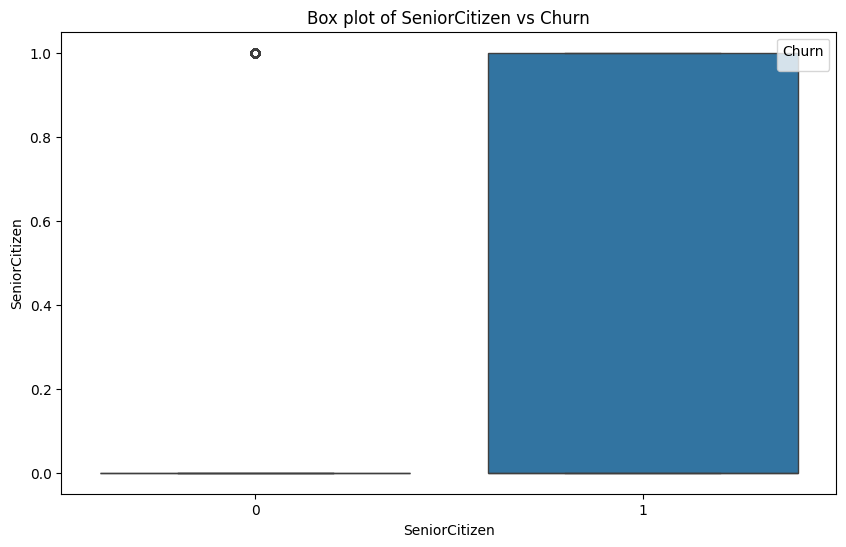

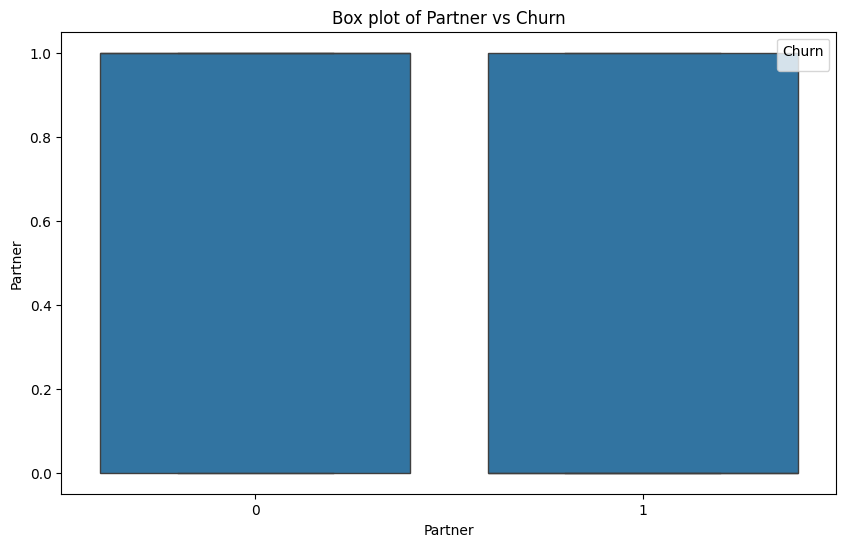

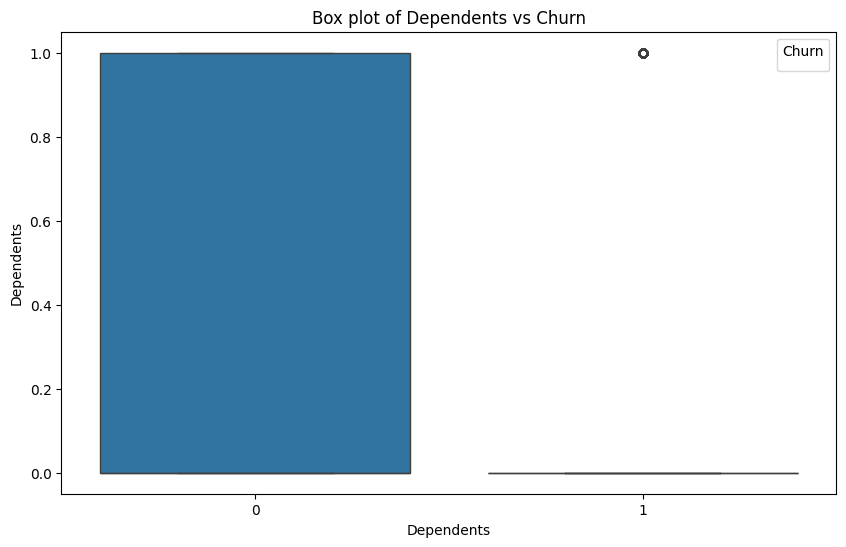

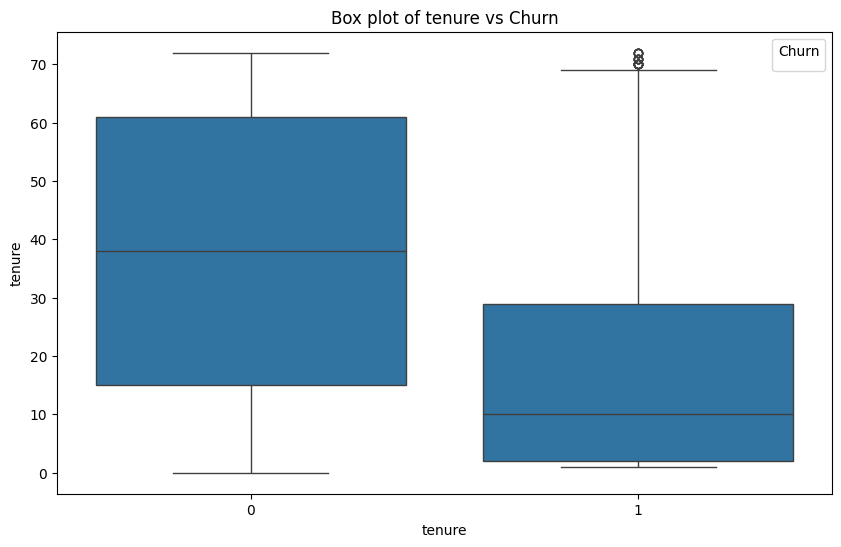

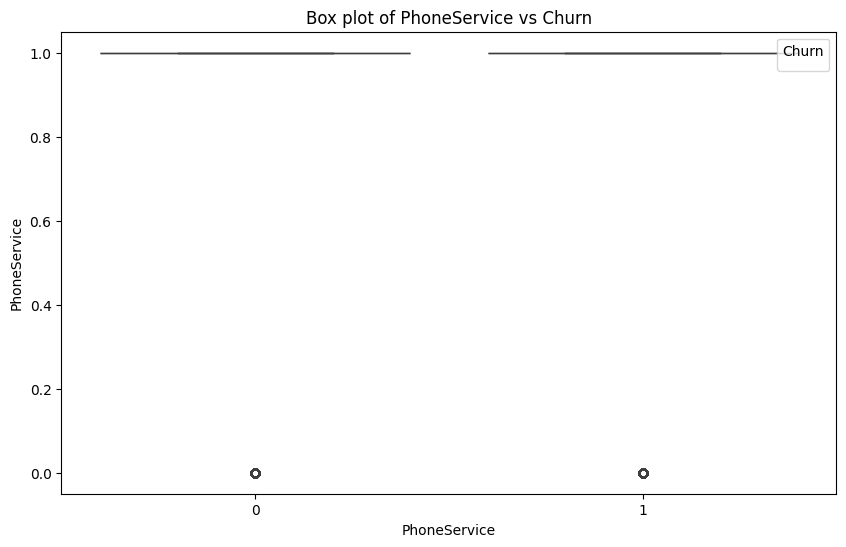

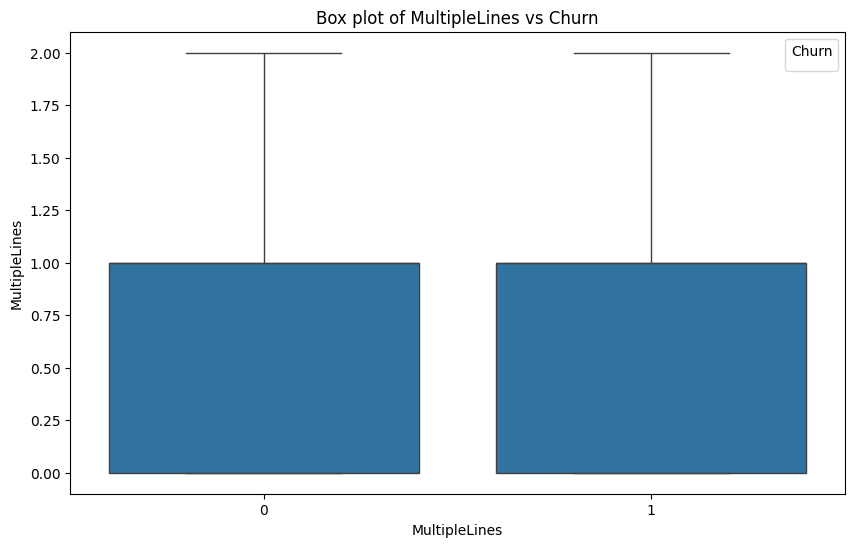

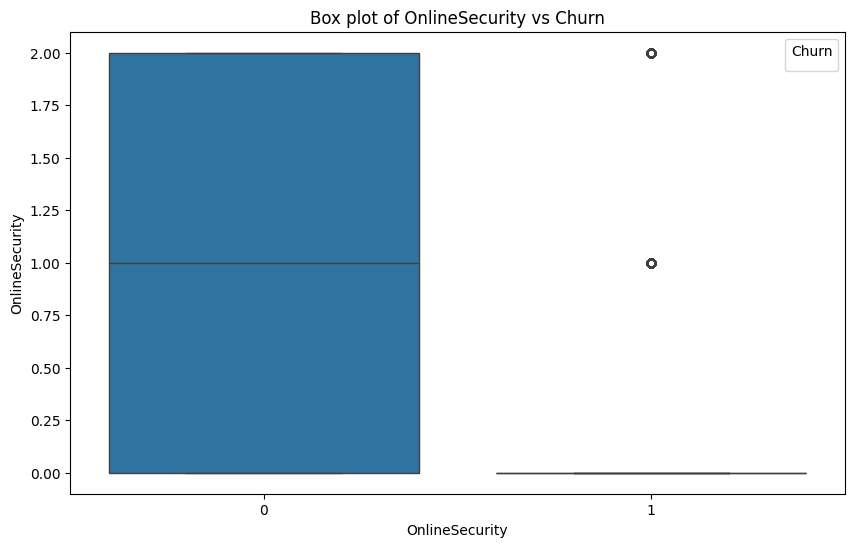

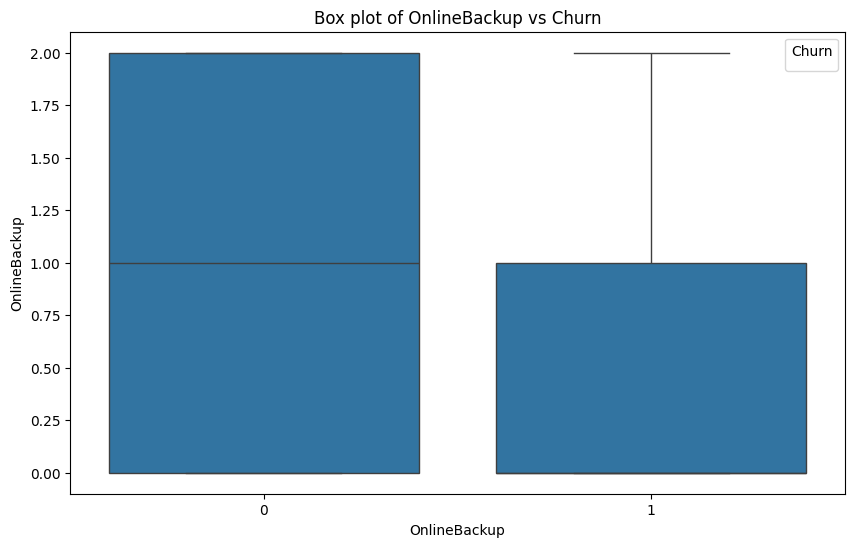

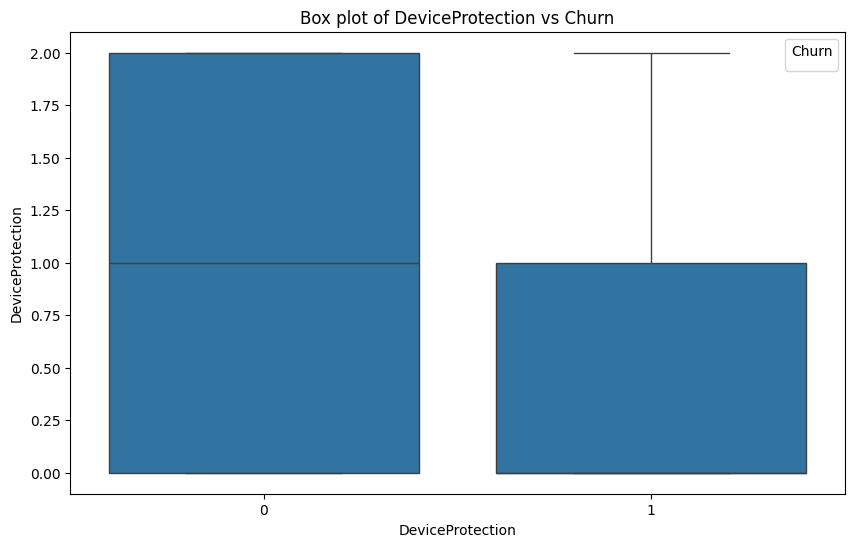

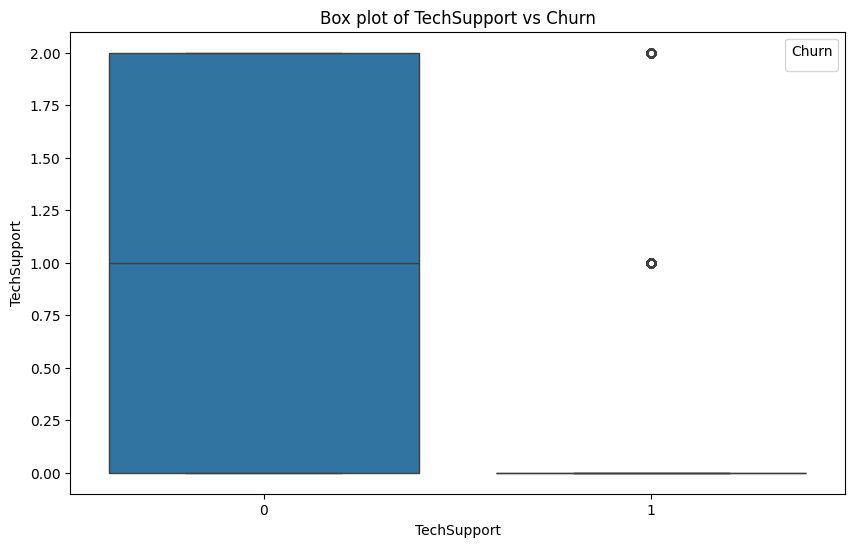

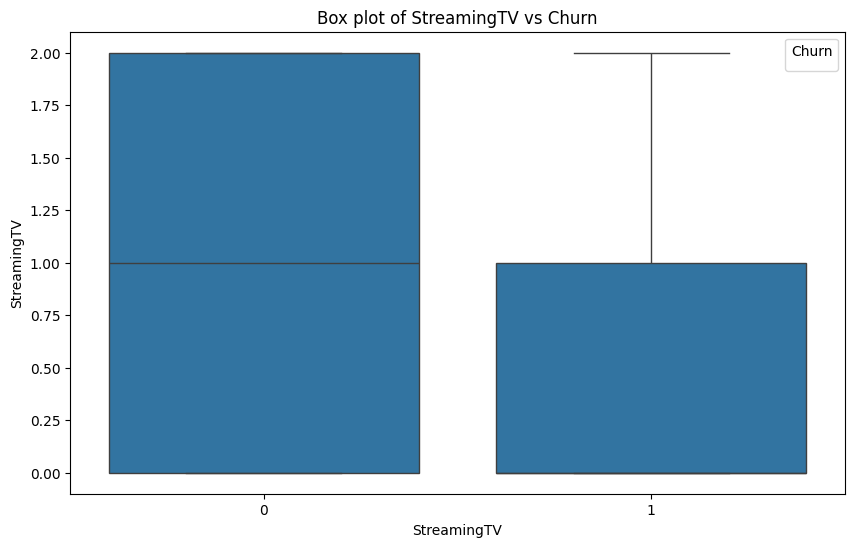

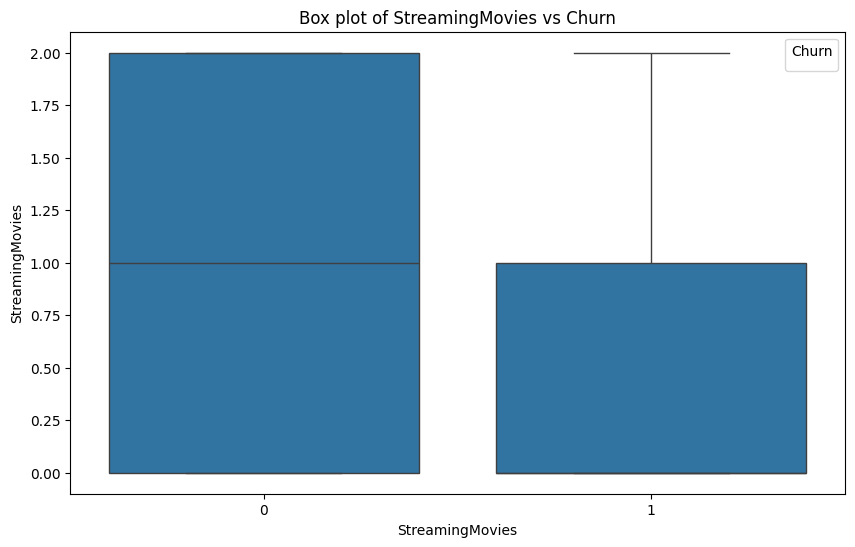

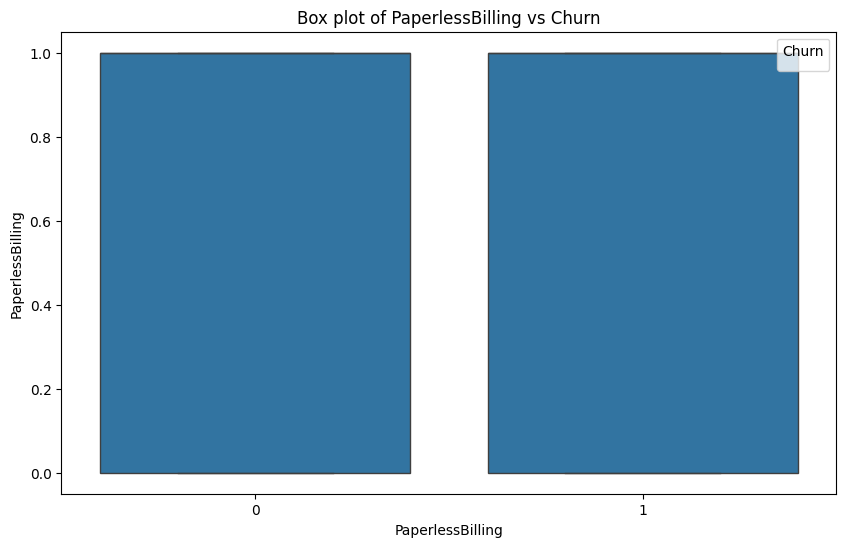

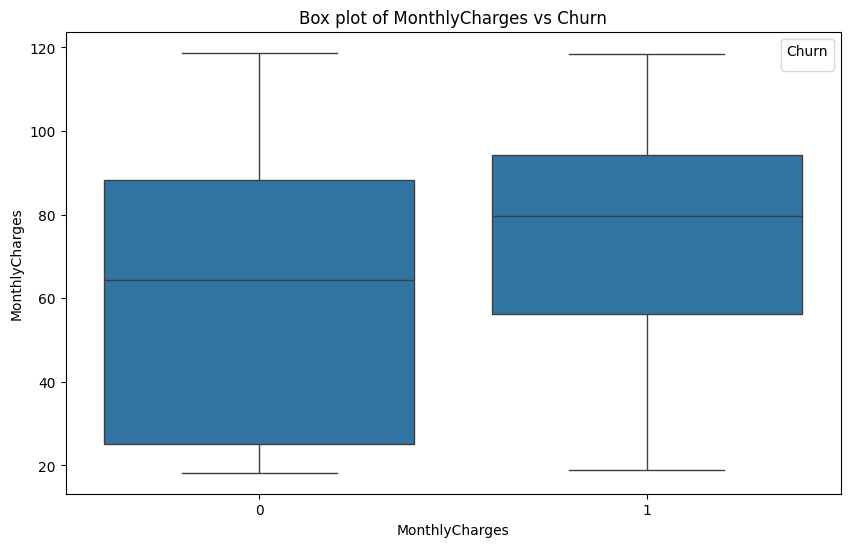

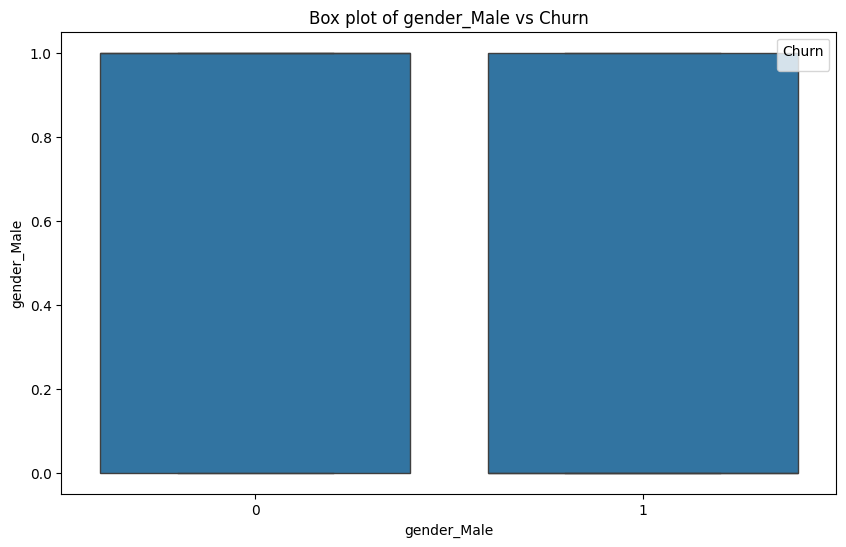

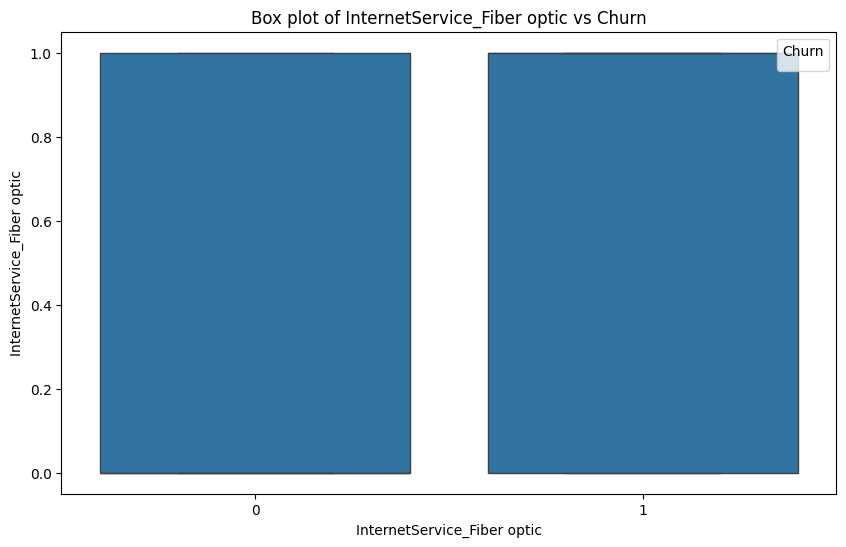

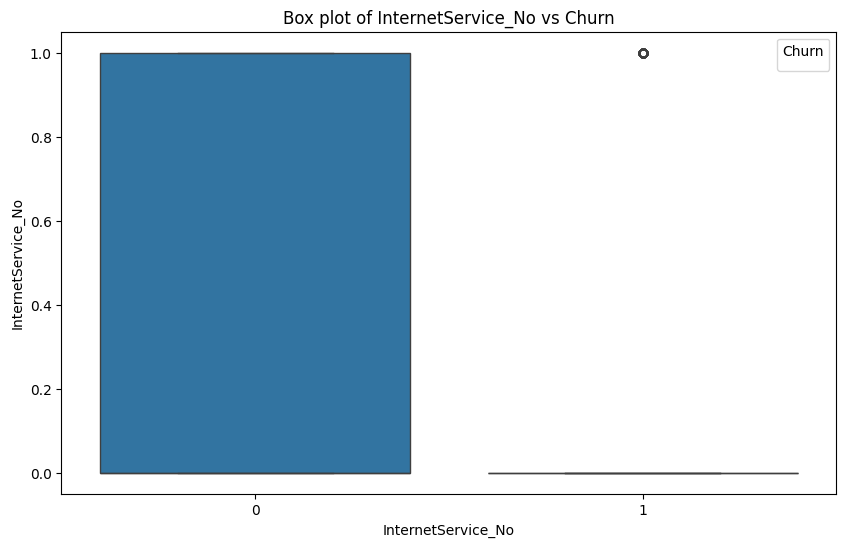

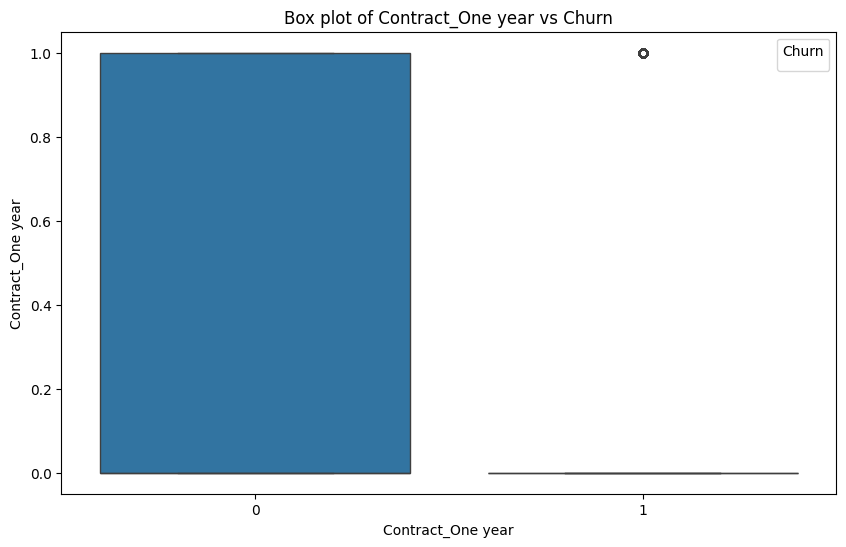

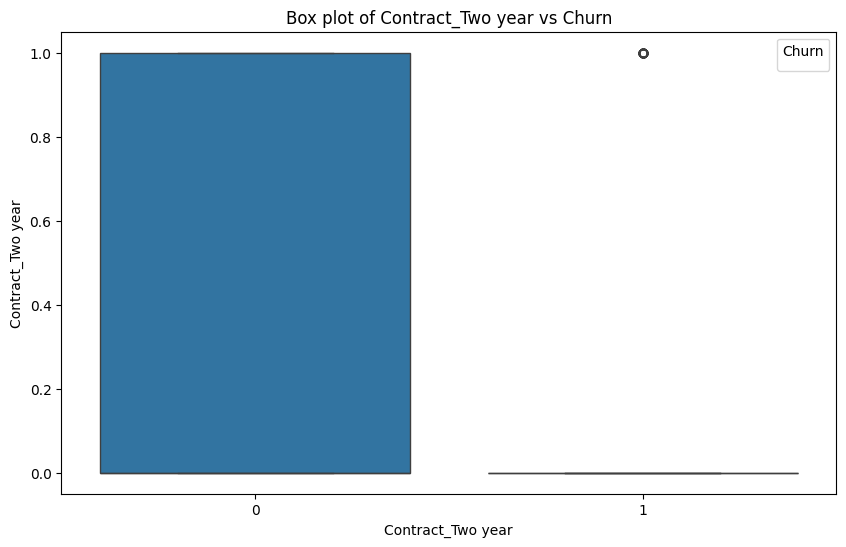

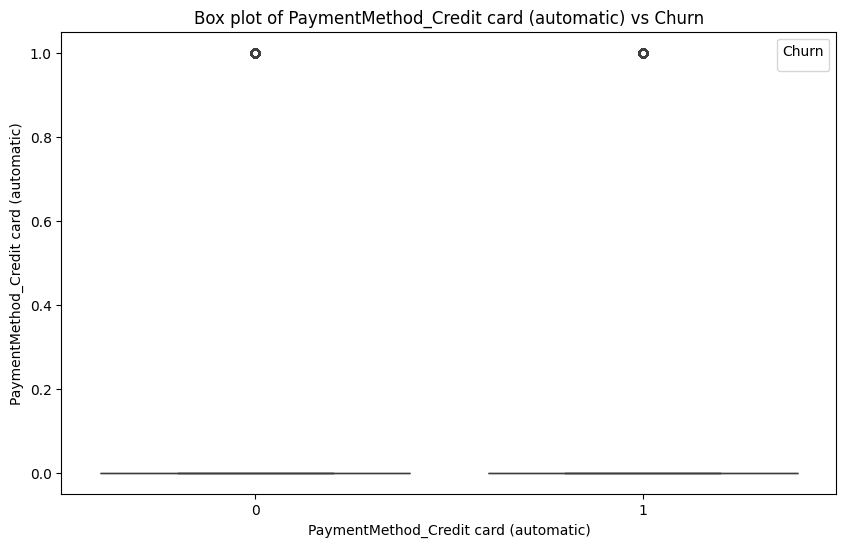

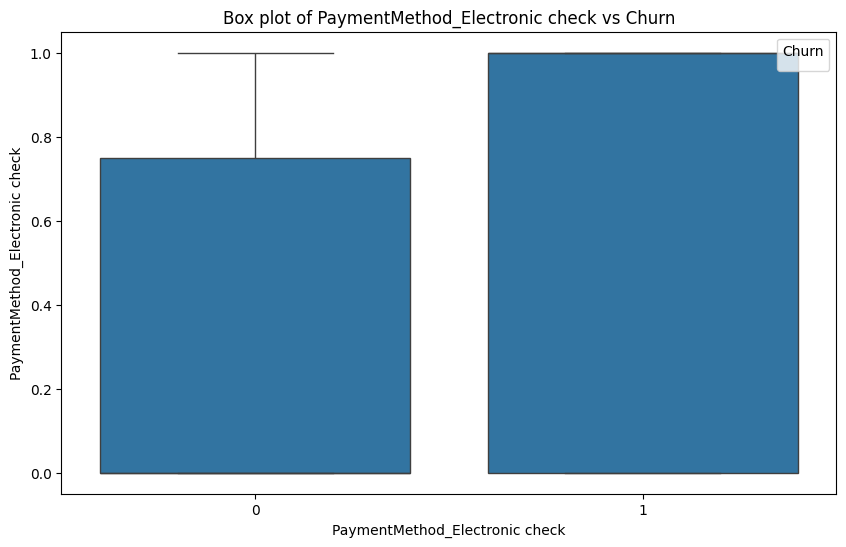

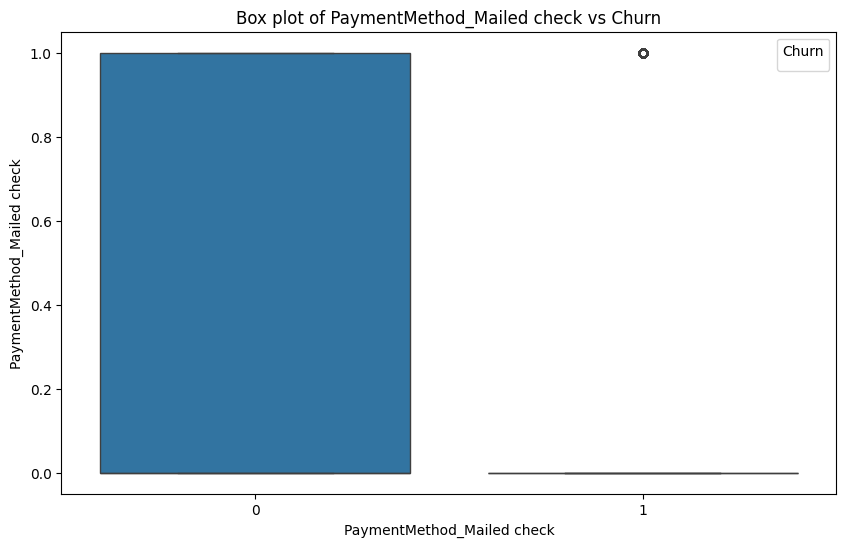

In [12]:
#Checks the relationships for each feature
for column in X.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=y, y=X[column])
    plt.title(f'Box plot of {column} vs Churn')


    plt.xlabel(column)
    plt.ylabel('Count' if X[column].dtype == 'object' else column)
    plt.legend(title='Churn', loc='upper right')
    plt.show()


# Linear Regression

In [13]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.2f}")
    print(f"R2 Score: {r2:.2f}")

    for feature, coef in zip(X.columns, model.coef_):
      print(f"{feature}: {coef:.4f}")

    print(f"Intercept: {model.intercept_}")

    return model, y_pred

In [14]:
# Fit models
lr_model, lr_pred = evaluate_model(LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression")
ridge_model, ridge_pred = evaluate_model(Ridge(alpha=1.0), X_train_scaled, X_test_scaled, y_train, y_test, "Ridge Regression")
lasso_model, lasso_pred = evaluate_model(Lasso(alpha=0.1), X_train_scaled, X_test_scaled, y_train, y_test, "Lasso Regression")


Linear Regression:
MSE: 0.14
R2 Score: 0.30
SeniorCitizen: 0.0141
Partner: 0.0031
Dependents: -0.0098
tenure: -0.1096
PhoneService: 0.0545
MultipleLines: 0.0436
OnlineSecurity: -0.0362
OnlineBackup: -0.0105
DeviceProtection: 0.0094
TechSupport: -0.0293
StreamingTV: 0.0621
StreamingMovies: 0.0759
PaperlessBilling: 0.0222
MonthlyCharges: -0.1688
gender_Male: -0.0047
InternetService_Fiber optic: 0.1359
InternetService_No: -0.1901
Contract_One year: -0.0440
Contract_Two year: -0.0311
PaymentMethod_Credit card (automatic): -0.0021
PaymentMethod_Electronic check: 0.0348
PaymentMethod_Mailed check: -0.0054
Intercept: 0.265530706425275

Ridge Regression:
MSE: 0.14
R2 Score: 0.30
SeniorCitizen: 0.0141
Partner: 0.0031
Dependents: -0.0098
tenure: -0.1095
PhoneService: 0.0382
MultipleLines: 0.0376
OnlineSecurity: -0.0435
OnlineBackup: -0.0175
DeviceProtection: 0.0023
TechSupport: -0.0366
StreamingTV: 0.0483
StreamingMovies: 0.0622
PaperlessBilling: 0.0222
MonthlyCharges: -0.1143
gender_Male: -0.0

The intercept represents the starting parameter of the model if all the values happen to be 0. In this case, the churn would be 0.27, closer to a churn of 0 than  1.

The intercepts represent the incremental rate of change as X increases by 1 unit.

Based on the LASSO regression model, the best performing features are tenure, online security, tech support, internet service, and fiber optic.

A very low MSE indicates the model is accurate. However, a very low R2 value showcases a poor explanatory power that the features have on the predictions.

This model is hard to interpret, not only because of the vast amount of features, but the features' weights are determined by other features.

<Figure size 1200x600 with 0 Axes>

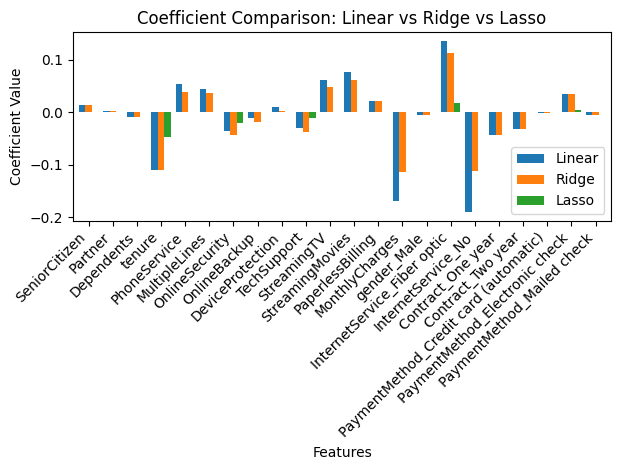

In [15]:
# Coefficient Comparison Plot
def plot_coefficients(lr_model, ridge_model, lasso_model):
    coef_df = pd.DataFrame({
        'Linear': lr_model.coef_,
        'Ridge': ridge_model.coef_,
        'Lasso': lasso_model.coef_
    }, index=X.columns)

    plt.figure(figsize=(12, 6))
    coef_df.plot(kind='bar', width=0.8)
    plt.title('Coefficient Comparison: Linear vs Ridge vs Lasso')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.legend(loc='best')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_coefficients(lr_model, ridge_model, lasso_model)


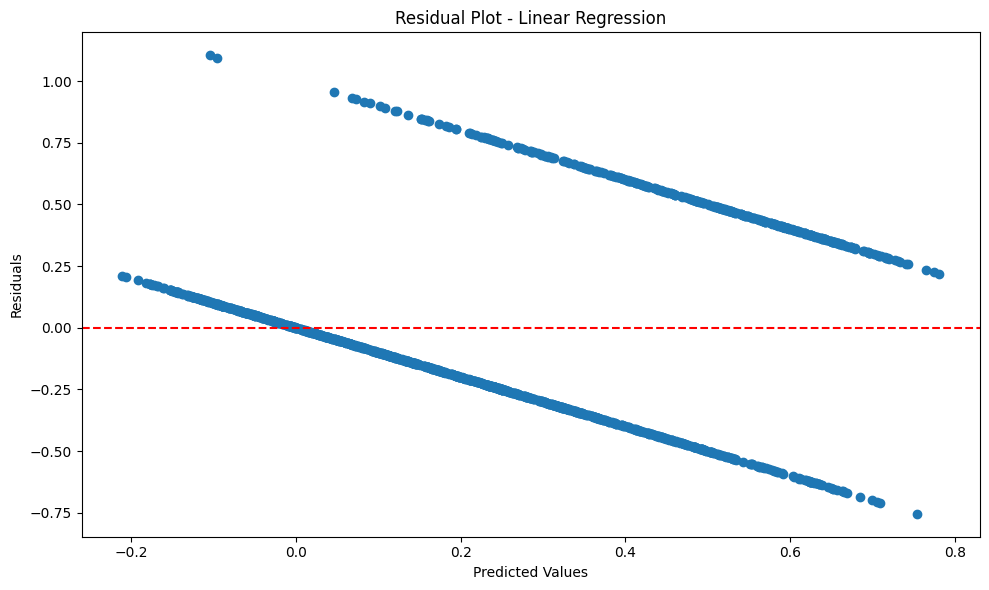

In [16]:
# Residual Plot
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot - {model_name}')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.tight_layout()
    plt.show()

plot_residuals(y_test, lr_pred, 'Linear Regression')

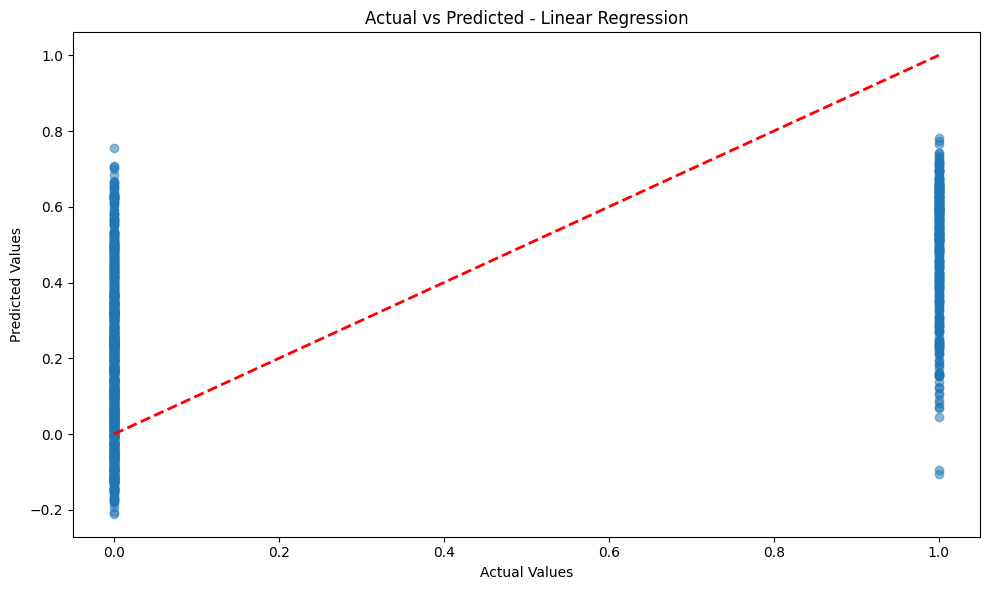

In [17]:
# Actual vs Predicted Plot
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted - {model_name}')
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(y_test, lr_pred, 'Linear Regression')


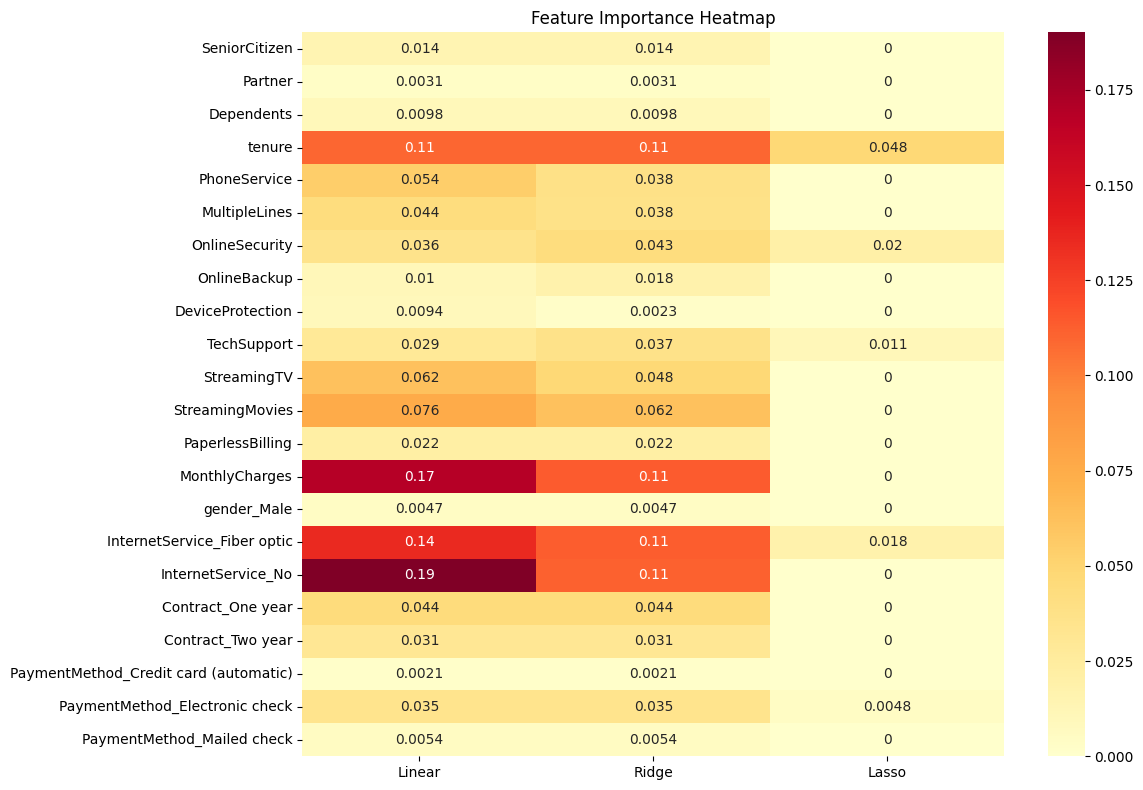

In [18]:
# Feature Importance Heatmap
def plot_feature_importance_heatmap(lr_model, ridge_model, lasso_model):
    importance_df = pd.DataFrame({
        'Linear': np.abs(lr_model.coef_),
        'Ridge': np.abs(ridge_model.coef_),
        'Lasso': np.abs(lasso_model.coef_)
    }, index=X.columns)

    plt.figure(figsize=(12, 8))
    sns.heatmap(importance_df, annot=True, cmap='YlOrRd')
    plt.title('Feature Importance Heatmap')
    plt.tight_layout()
    plt.show()

plot_feature_importance_heatmap(lr_model, ridge_model, lasso_model)

## Linearity
Based on the predicted and actual values, even though the actual values are between 0 and 1, there does appear to be a linear relationship as shown by the red line.

## Normality

Shapiro-Wilk Test: Statistic=0.9656315445899963, p-value=8.918417346266041e-18


<Figure size 800x600 with 0 Axes>

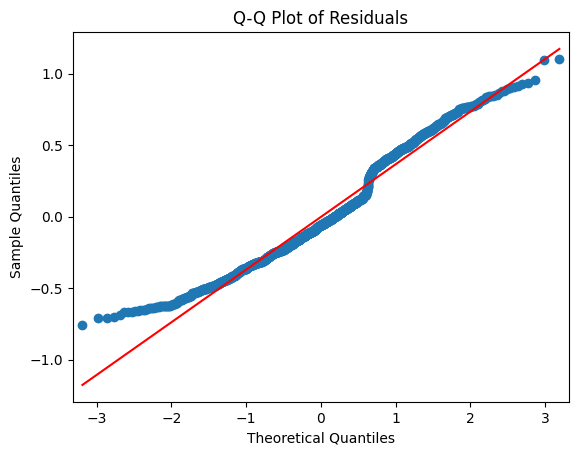

In [19]:
residuals = y_test - lr_pred

# Shapiro-Wilk test
shapiro_test = stats.shapiro(residuals)
print(f'Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}')

# Q-Q plot
plt.figure(figsize=(8, 6))
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()


The data does appear to be normally distributed, because the SW test yeilds an extremely small p value, and the QQ plot yields



## Homoscedasticity

In [20]:
# Fit the model with statsmodels for testing
X_const = sm.add_constant(X_train)  # Add a constant for intercept
model_stats = sm.OLS(y_train, X_const).fit()

# Perform Breusch-Pagan test for Homoscedaticity
bp_test = het_breuschpagan(model_stats.resid, model_stats.model.exog)
bp_results = dict(zip(['LM Statistic', 'LM-Test p-value', 'F Statistic', 'F-Test p-value'], bp_test))
print(bp_results)


{'LM Statistic': 1138.2802848681824, 'LM-Test p-value': 6.694074868455402e-227, 'F Statistic': 64.5754697912307, 'F-Test p-value': 1.0020597621798508e-254}


Based on extremely low p-values, we can assume the null hypothesis and conclude that the resdiuals of the data are distributed with equal variance.

In [21]:
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


                                  Feature         VIF
0                           SeniorCitizen    1.376378
1                                 Partner    2.827325
2                              Dependents    1.974470
3                                  tenure    7.621940
4                            PhoneService  230.304329
5                           MultipleLines   12.173255
6                          OnlineSecurity   13.594660
7                            OnlineBackup   12.522852
8                        DeviceProtection   13.197584
9                             TechSupport   13.897184
10                            StreamingTV   27.631335
11                        StreamingMovies   27.967037
12                       PaperlessBilling    2.946640
13                         MonthlyCharges  777.049241
14                            gender_Male    2.017074
15            InternetService_Fiber optic   42.556738
16                     InternetService_No  396.047587
17                      Cont

There appears to be a high multicollinearity with the Phone Service, Multiple Lines, Online Security, Online Backup, Device Protection, Tech Support, Streaming TV, Streaming Movies, Monthly Charges, and the Internet

# Logistic Regression

In [22]:
# Split the DataFrame into X and y
X = df.drop(columns=['Churn'])
y = df['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

# Get the coefficients and intercept
coefficients = model.coef_[0]
intercept = model.intercept_[0]

coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})
print(coefficients_df)
print(f'Intercept: {intercept}')


Accuracy: 0.808374733853797
Confusion Matrix:
[[923 114]
 [156 216]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1037
           1       0.65      0.58      0.62       372

    accuracy                           0.81      1409
   macro avg       0.75      0.74      0.74      1409
weighted avg       0.80      0.81      0.80      1409

                                  Feature  Coefficient
0                           SeniorCitizen     0.202122
1                                 Partner     0.033671
2                              Dependents    -0.203394
3                                  tenure    -0.034167
4                            PhoneService     0.043517
5                           MultipleLines     0.305188
6                          OnlineSecurity    -0.294527
7                            OnlineBackup    -0.165118
8                        DeviceProtection    -0.006249
9                             T

The intercept is the odds outcome when all the features equate to 0. In this case, the odds are -1, which means that at least a few features are reuqired for a prediciton to be made.

Each coefficient represents the change in the odds outcome as the predictor variable increases by 1.

This model is fairly accurate, keeping an 80% accuracy. The most significant features include Senior citizens, MultipleLines, OnlineSecurity, StreamingTV and Movies, PaperlessBilling, InternetService, and contract.

However, the interpretability is harder to have than linear regression, as the model weights are multiplicative rather than additive.

## Linearity

Optimization terminated successfully.
         Current function value: 0.414417
         Iterations 8


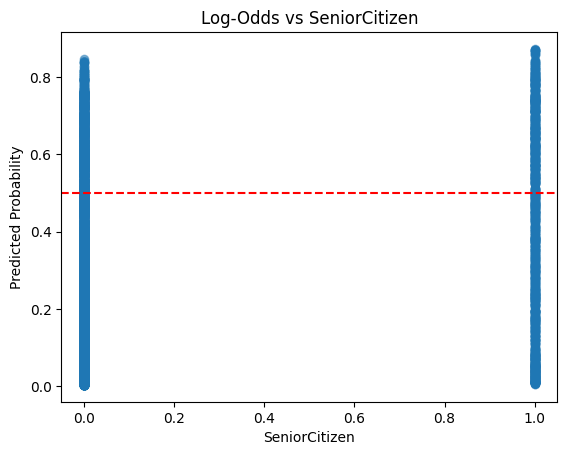

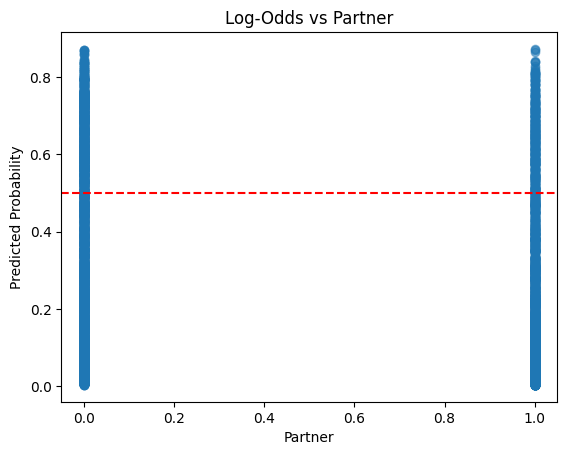

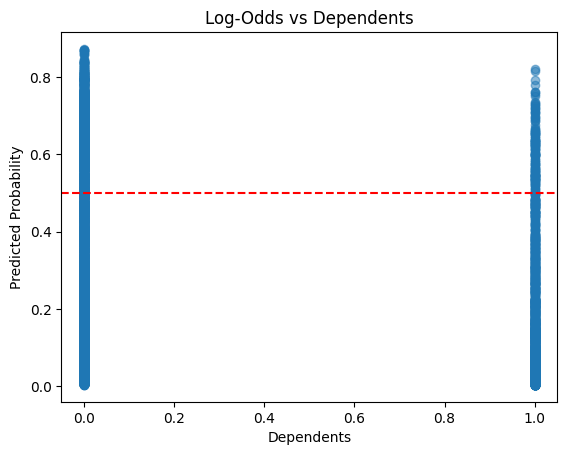

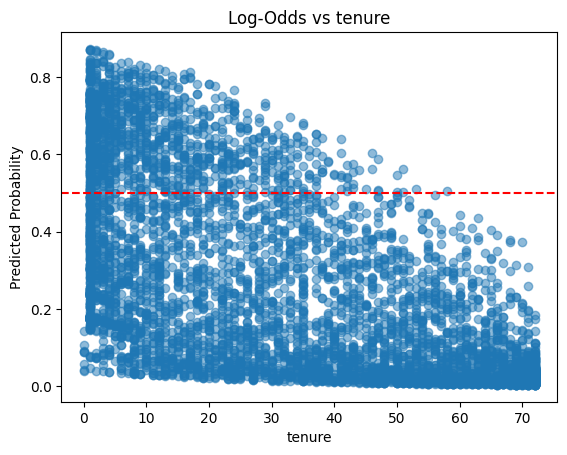

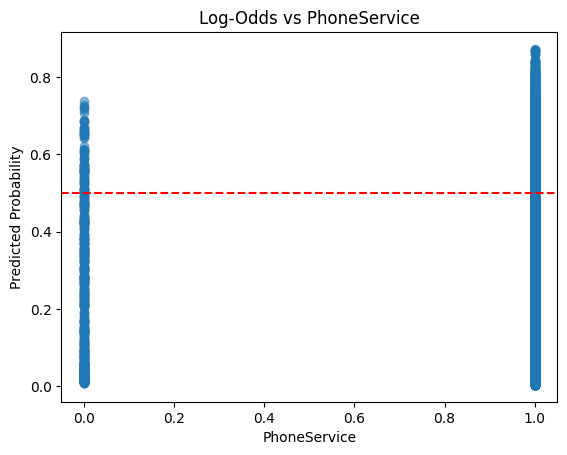

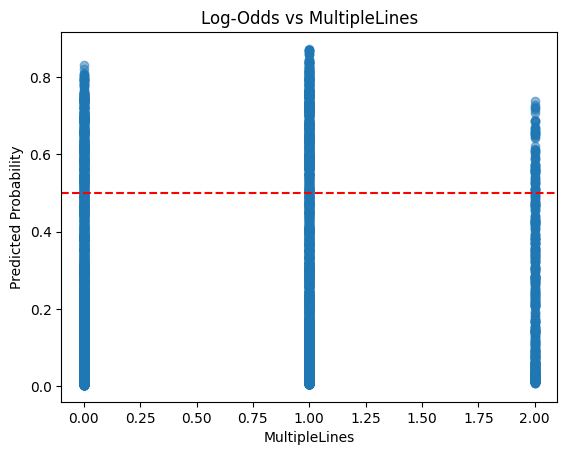

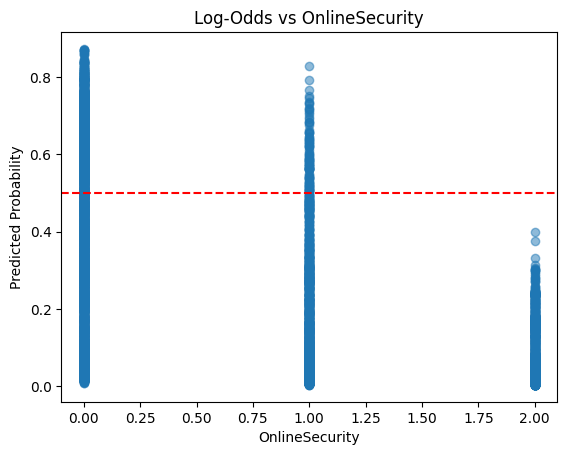

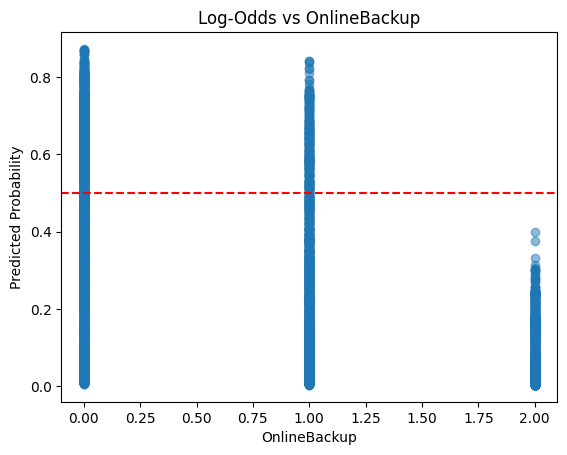

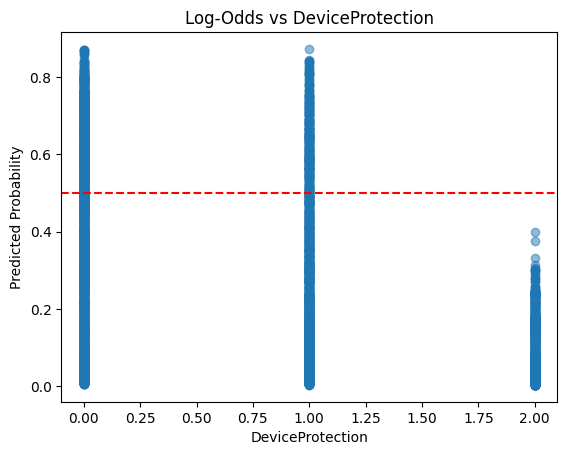

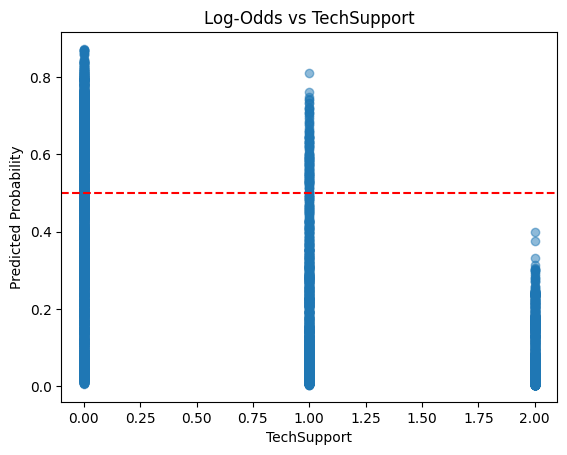

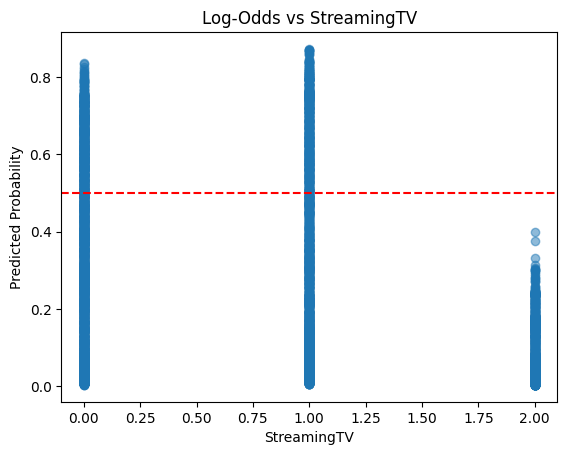

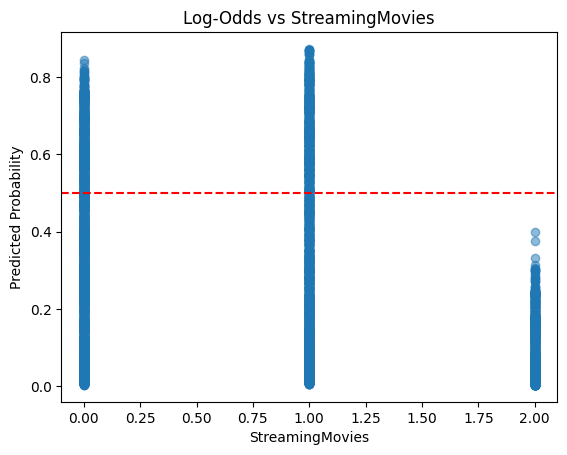

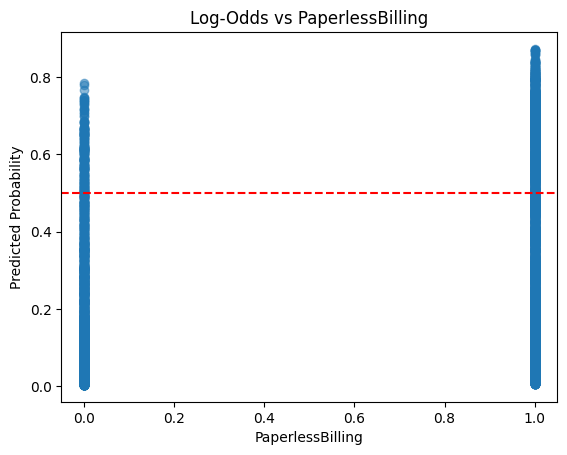

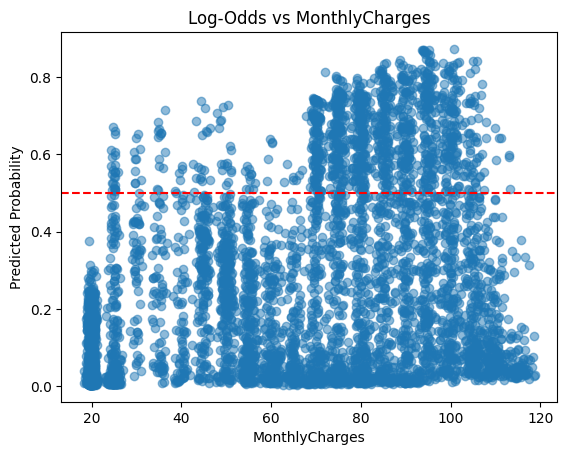

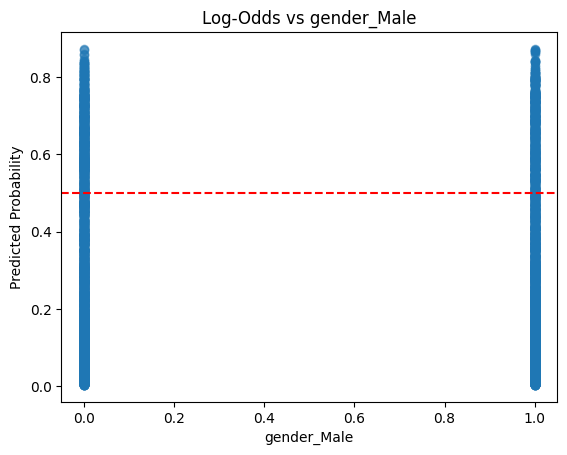

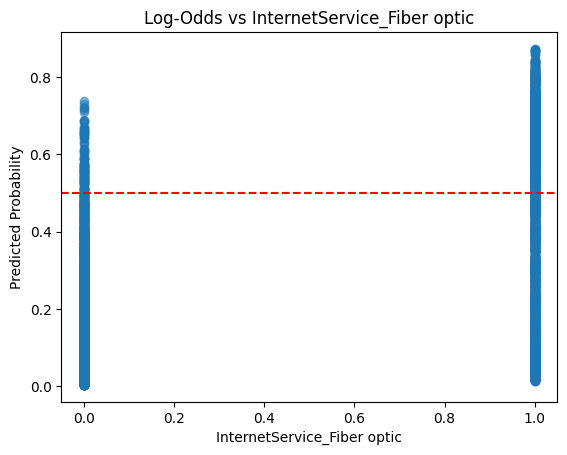

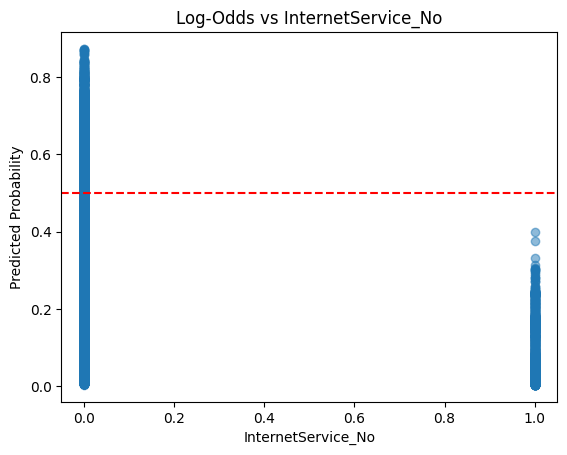

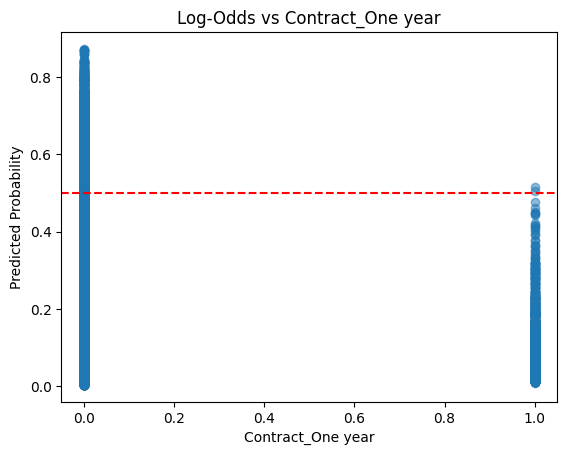

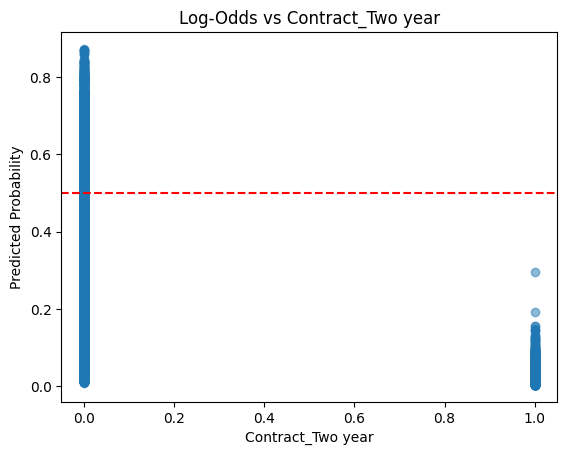

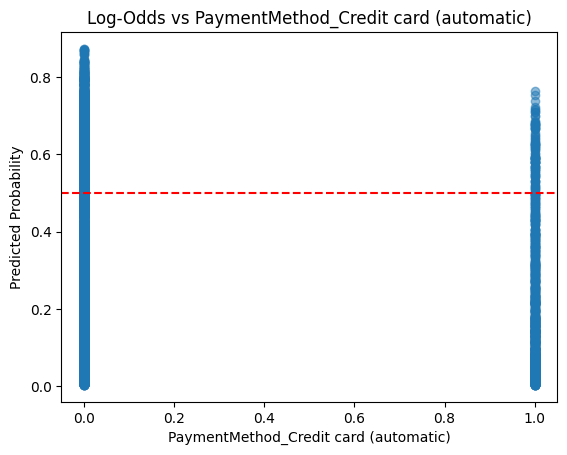

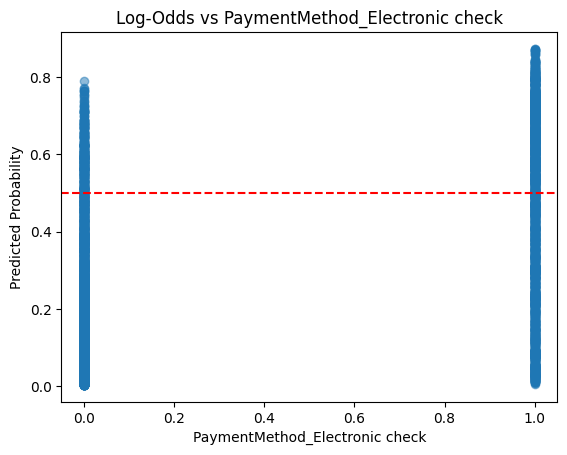

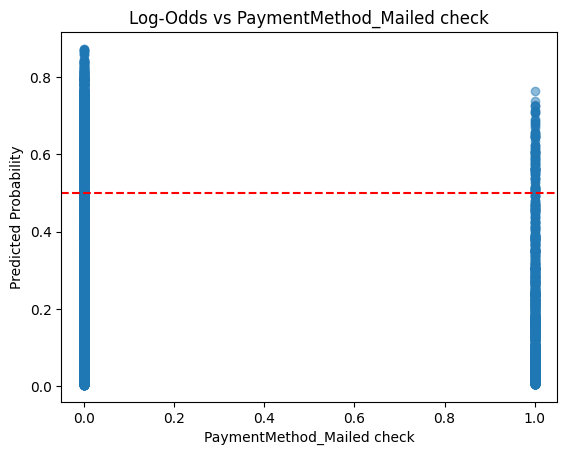

In [23]:
# Fit the model using statsmodels
X_sm = sm.add_constant(X_train)  # Add intercept
logit_model = sm.Logit(y_train, X_sm)
result = logit_model.fit()

# Plot the log-odds against each continuous variable
for col in X_train.select_dtypes(include=['float64', 'int64']).columns:
    plt.scatter(X_train[col], result.predict(X_sm), alpha=0.5)
    plt.xlabel(col)
    plt.ylabel('Predicted Probability')
    plt.title(f'Log-Odds vs {col}')
    plt.axhline(y=0.5, color='r', linestyle='--')  # Decision boundary
    plt.show()


Most of the data depicts a linear relationship

## Multicollinearity

In [24]:
# Calculate VIF for each feature
X_vif = sm.add_constant(X_train)
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)


                                  Feature          VIF
0                                   const   249.818017
1                           SeniorCitizen     1.155321
2                                 Partner     1.452741
3                              Dependents     1.386844
4                                  tenure     2.724589
5                            PhoneService    76.114825
6                           MultipleLines    12.800304
7                          OnlineSecurity    19.580207
8                            OnlineBackup    18.217344
9                        DeviceProtection    18.539004
10                            TechSupport    19.890199
11                            StreamingTV    59.931004
12                        StreamingMovies    59.232564
13                       PaperlessBilling     1.216651
14                         MonthlyCharges   859.329465
15                            gender_Male     1.002912
16            InternetService_Fiber optic   147.481879
17        

A lot of datapoints have high multicollinearity.

Influential Outliers

In [25]:
influence = result.get_influence()
cooks_d = influence.cooks_distance[0]

# Identify influential points
influential_points = np.where(cooks_d > 4 / len(X_train))[0]
print(f'Influential points indices: {influential_points}')

print(f'Influential outliers percentage: {len(influential_points)/len(X_train)}')


Influential points indices: [  11   48   82   88   96  116  129  157  169  187  211  226  228  247
  270  274  291  305  352  357  368  369  440  455  464  465  495  539
  547  551  562  579  605  626  664  681  695  697  700  731  741  744
  773  859  867  871  911  954  960  984  992  998 1000 1005 1028 1033
 1076 1120 1138 1142 1157 1208 1212 1218 1232 1234 1237 1263 1264 1275
 1290 1299 1303 1310 1322 1339 1347 1354 1379 1410 1437 1458 1470 1509
 1525 1531 1585 1627 1628 1663 1687 1705 1712 1714 1719 1723 1741 1768
 1792 1799 1813 1838 1843 1846 1852 1879 1903 1910 1929 1954 1976 1979
 1982 1987 2010 2037 2069 2070 2112 2118 2144 2159 2179 2216 2244 2278
 2302 2341 2372 2395 2396 2492 2499 2503 2506 2512 2540 2547 2575 2576
 2581 2590 2645 2687 2706 2710 2731 2749 2790 2797 2823 2826 2863 2895
 2935 2999 3013 3023 3024 3031 3074 3099 3115 3125 3153 3154 3170 3187
 3189 3197 3222 3236 3240 3258 3272 3286 3296 3297 3310 3318 3338 3347
 3351 3352 3356 3372 3396 3423 3425 3438 3443 346

Using Cook's distance, only 5.6% of the data could be seen as influential outliers. This is not significant

# GAM

In [26]:
# Initilize GAM
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) +
                s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) +
                s(18) + s(19) + s(20) + s(21))


# Find best smoothing parameters for each spline term
gam.gridsearch(X_train_scaled, y_train)

# Fit the model
gam.fit(X_train_scaled, y_train)

# Make predictions
y_pred_gam = gam.predict(X_test_scaled)

# Calculate MSE and R^2
mse_gam = mean_squared_error(y_test, y_pred_gam)
r2_gam = r2_score(y_test, y_pred_gam)

print(f"GAM MSE: {mse_gam:.4f}, R^2: {r2_gam:.4f}")

gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:36 Time:  0:00:36


GAM MSE: 0.1945, R^2: -0.0009
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     29.2273
Link Function:                     IdentityLink Log Likelihood:                                -10321.4323
Number of Samples:                         5634 AIC:                                            20703.3192
                                                AICc:                                           20703.6561
                                                GCV:                                                0.1972
                                                Scale:                                              0.1954
                                                Pseudo R-Squared:                                   0.0038
Feature

<ipython-input-26-936ee74642ce>:22: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


The intercept represents the the base level when all the predictors are at their average.

The coefficients represent the effect of the predictor variable after accounting for the nonlinear relationships.

While this model has a low MSE, showing the accuracy of the model, the model itself has an extremely low R^2, meaning that the model explains only a small amount of the variance in the model.

While the model helps with nonlinear relationships, making such modifications to the data can reduce interpretability.

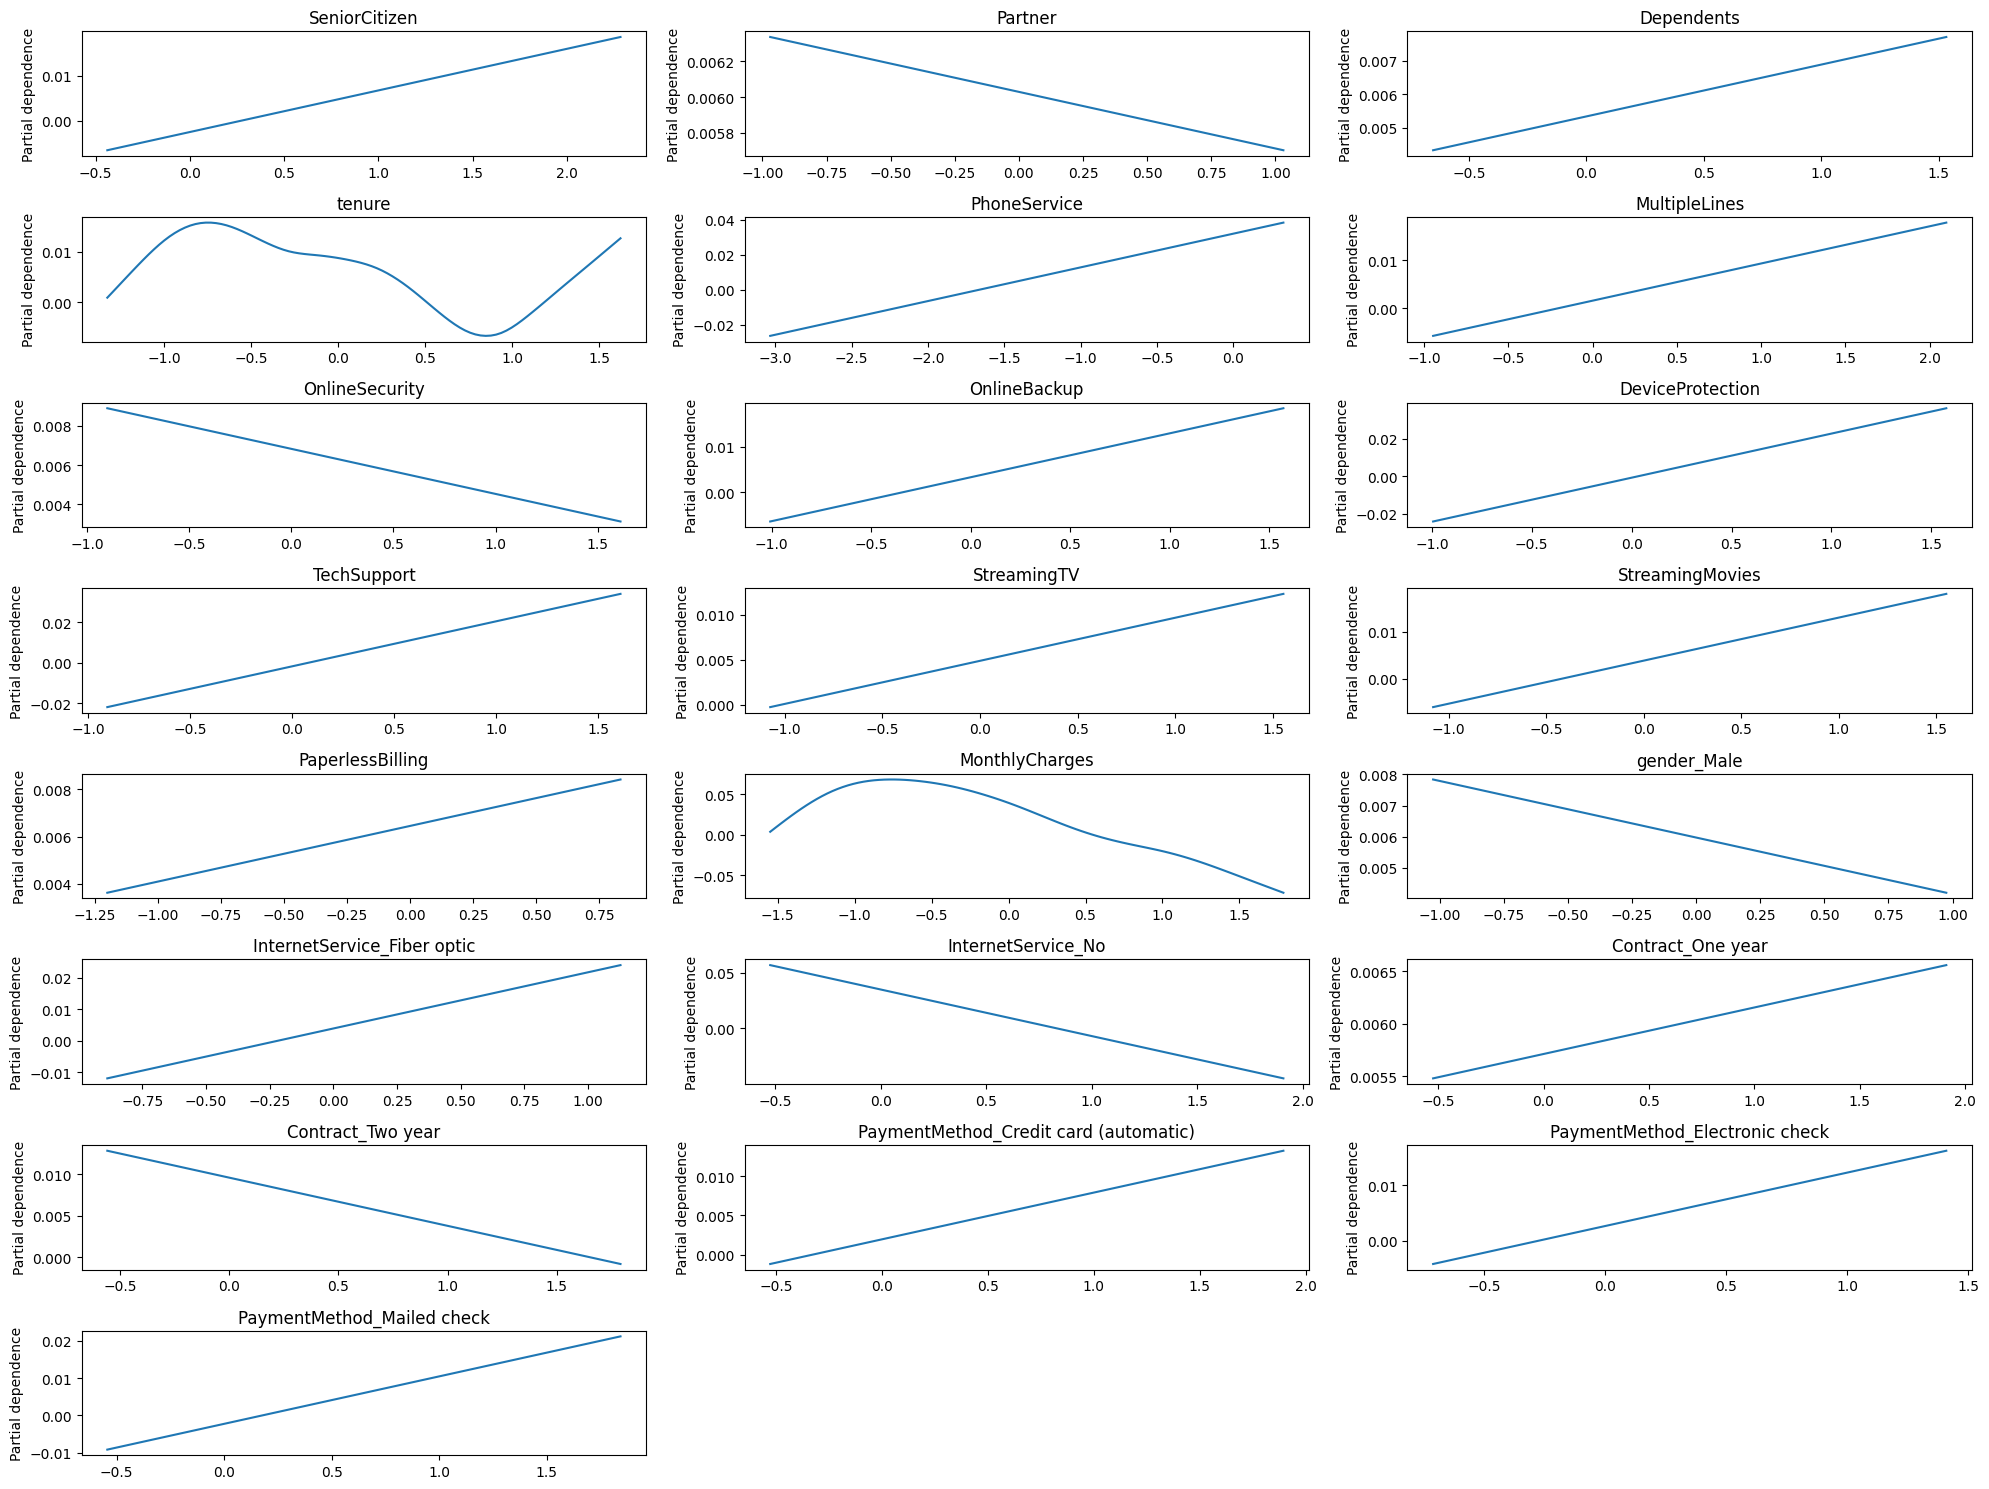

In [27]:
# Visualize GAM
plt.figure(figsize=(20, 15))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.subplot(8, 3, i+1)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX))
    plt.title(X_train.columns[i])
    plt.ylabel('Partial dependence')
plt.tight_layout()
plt.show()

## Multicolinearity

In [28]:
# Calculate VIF for each feature
X_with_const = sm.add_constant(X_train)
vif = pd.DataFrame()
vif['Feature'] = X_with_const.columns
vif['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

print(vif)


                                  Feature          VIF
0                                   const   249.818017
1                           SeniorCitizen     1.155321
2                                 Partner     1.452741
3                              Dependents     1.386844
4                                  tenure     2.724589
5                            PhoneService    76.114825
6                           MultipleLines    12.800304
7                          OnlineSecurity    19.580207
8                            OnlineBackup    18.217344
9                        DeviceProtection    18.539004
10                            TechSupport    19.890199
11                            StreamingTV    59.931004
12                        StreamingMovies    59.232564
13                       PaperlessBilling     1.216651
14                         MonthlyCharges   859.329465
15                            gender_Male     1.002912
16            InternetService_Fiber optic   147.481879
17        

Some features have a high multicollinearity

## Model Selection

Choosing a model requires the measure of accuracy and interpretability. While the Logistic Regression model has a high accuracy and the GAM takes account of nonlinear relationships, making modifications to the data end up reducing interpretability. If you want the most interpretable model, then a Linear Regression is the best scenario, as the coefficients are easy to interpret. The strength of each feature is shown in the regression function.

The 3 most important features in this linear model (see heatmap) are tenure, the monthly charges, and the state of Internet Services.